# Import libraries

In [53]:
# Reload modules
%load_ext autoreload
%autoreload 2
# Inline plots
%matplotlib inline

# Standard
import numpy as np
import matplotlib.pyplot as plt
import time as time
from copy import deepcopy

# tf
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# Mine
from utility import display_image, permutate # Utilities
from model import Net   # Model definition
from train import train # Training code

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set parameters

In [54]:
# Set random seed
num_seed = 1
tf.set_random_seed(num_seed)

# Training
N_task = 2       # Number of tasks
N_it = 800       # Number of iterations
batch_size = 100 # Number of samples in each minibatch

# Network
hidden_size = 50       # Number of hidden layer neurons

# Regularization and Fisher
lambda_L2 = 0.025        # Regularization parameter for L2
lambda_EWC = 15         # Regularization parameter for EWC
sample_size_Fish = 200 # Number of samples to use to estimate Fisher Info.

# Miscellaneous
ep_rec = 20            # Record test accuracy every ep_rec iterations
ep_time = int(N_it/1) # Display time every ep_time iterations

# Load data

In [55]:
# Extract dataset
dataset = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


# Create permutated datasets

In [56]:
datasets = [dataset] # List of datasets

# Append permuted datasets
for i in range(N_task-1):
    datasets.append(permutate(dataset))

# Plot sample images

label = 0


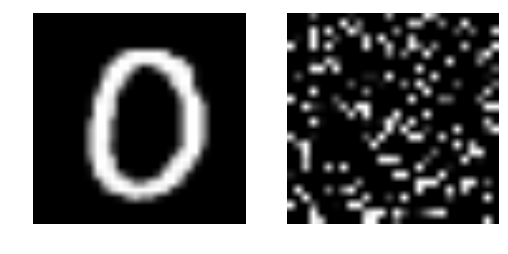

In [57]:
sample_index = 10      # Sample image to display
# Display label
label = datasets[0].train.labels[sample_index]
label = np.nonzero(label)[0][0]
print('label = ' + str(label))

# Display images
plt.figure()
for i in range(N_task):
    image = datasets[i].train.images[sample_index]

    plt.subplot(1,N_task,1+i)
    display_image(image)

# Create models

In [58]:
sess = tf.InteractiveSession() # Initialize session
# input and output placeholders
input_dim = datasets[0].train.images.shape[1]
output_dim = datasets[0].train.labels.shape[1]
inputs = tf.placeholder(tf.float32, shape=[None,input_dim])
outputs = tf.placeholder(tf.float32, shape=[None,output_dim])

# Instantiate models
tf.set_random_seed(num_seed)
model = Net(inputs,outputs,hidden_dim=50)
tf.set_random_seed(num_seed)
model_L2 = Net(inputs,outputs,hidden_dim=50)
tf.set_random_seed(num_seed)
model_EWC = Net(inputs,outputs,hidden_dim=50)

# Initialize variables
sess.run(tf.global_variables_initializer())

# Train

In [59]:
# Initialize test accuracy lists
test_acc_lists = []
test_acc_lists_L2 = []
test_acc_lists_EWC = []
for i in range(N_task):
    test_acc_lists.append(np.zeros([0]))
    test_acc_lists_L2.append(np.zeros([0]))
    test_acc_lists_EWC.append(np.zeros([0]))

time_start = time.time()
time_p1 = time.time()
print('------------------------------------------------------------')
for i in range(N_task):

    print('Task ' + str(i))
    print('------------------------------------------------------------')
    # Vanilla
    test_acc_list = train(sess,model,datasets[i],datasets,inputs,outputs,N_it,batch_size,0,0,ep_rec,ep_time)
    # L2
    test_acc_list_L2 = train(sess,model_L2,datasets[i],datasets,inputs,outputs,N_it,batch_size,1,lambda_L2,ep_rec,ep_time)
    # EWC
    test_acc_list_EWC = train(sess,model_EWC,datasets[i],datasets,inputs,outputs,N_it,batch_size,2,lambda_EWC,ep_rec,ep_time)
    
    # Save parameters
    model_L2.save_parameters()
    model_EWC.save_parameters()
    
    time_F1 = time.time()
    # Compute Fisher Info.
    model_EWC.compute_Fisher(datasets[i].validation.images,sess,sample_size_Fish)
    time_F2 = time.time()
    print('Fisher computation runtime: ' + str(time_F2-time_F1) + ' s')
    
    # Record test accuracies
    for j in range(N_task):
        test_acc_lists[j] = np.hstack([test_acc_lists[j],test_acc_list[j]])
        test_acc_lists_L2[j] = np.hstack([test_acc_lists_L2[j],test_acc_list_L2[j]])
        test_acc_lists_EWC[j] = np.hstack([test_acc_lists_EWC[j],test_acc_list_EWC[j]])
    
    time_p2 = time.time()
    print('Total runtime for task ' + str(i) + ': ' + str(time_p2-time_p1) + ' s')
    time_p1 = time_p2
    
    print('------------------------------------------------------------')
time_finish = time.time()  
print('Total runtime: ' + str(time_finish-time_start) + ' s')


------------------------------------------------------------
Task 0
------------------------------------------------------------
Vanilla training runtime: 19.225703239440918 s
L2 training runtime: 27.92793560028076 s
EWC training runtime: 21.70174217224121 s
Fisher computation runtime: 945.5225551128387 s
Total runtime for task 0: 1041.5452692508698 s
------------------------------------------------------------
Task 1
------------------------------------------------------------
Vanilla training runtime: 24.107614040374756 s
L2 training runtime: 27.427019834518433 s
blah_EWC
EWC training runtime: 22.967389583587646 s
Fisher computation runtime: 909.7682087421417 s
Total runtime for task 1: 1034.886968612671 s
------------------------------------------------------------
Total runtime: 2076.4322378635406 s


# Plot

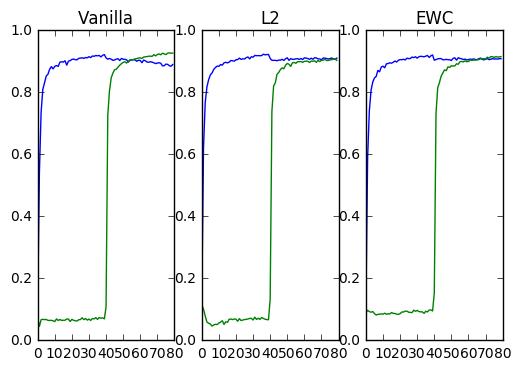

In [60]:
plt.figure()

plt.subplot(1,3,1)
plt.title('Vanilla')
plt.subplot(1,3,2)
plt.title('L2')
plt.subplot(1,3,3)
plt.title('EWC')
for i in range(N_task):
    plt.subplot(1,3,1)
    plt.plot(test_acc_lists[i],label='Task ' + str(i))
    plt.subplot(1,3,2)
    plt.plot(test_acc_lists_L2[i],label='Task ' + str(i))
    plt.subplot(1,3,3)
    plt.plot(test_acc_lists_EWC[i],label='Task ' + str(i))

plt.show()

In [61]:
#a=tf.constant(0.1,shape=[50])
#x = tf.placeholder(tf.float32,shape=[None,10])
#a=tf.random_uniform([5,3])
#a.eval()